
=== INTERNAL 70/30 | BorderlineSMOTE train-only ===
Epoch 1/30
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 48s 18ms/step - accuracy: 0.9489 - loss: 0.1580 - val_accuracy: 0.8501 - val_loss: 0.4253 - learning_rate: 0.0010
Epoch 2/30
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.9786 - loss: 0.0750 - val_accuracy: 0.9397 - val_loss: 0.1911 - learning_rate: 0.0010
Epoch 3/30
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 38s 16ms/step - accuracy: 0.9825 - loss: 0.0641 - val_accuracy: 0.9755 - val_loss: 0.0686 - learning_rate: 0.0010
Epoch 4/30
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 37s 17ms/step - accuracy: 0.9844 - loss: 0.0587 - val_accuracy: 0.9806 - val_loss: 0.0638 - learning_rate: 0.0010
Epoch 5/30
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 84s 36ms/step - accuracy: 0.9854 - loss: 0.0558 - val_accuracy: 0.9761 - val_loss: 0.0760 - learning_rate: 0.0010
Epoch 6/30
2186/2186 ━━━━━━━━━━━━━━━━━━━━ 64s 29ms/step - accuracy: 0.9862 - loss: 0.0532 - val_accuracy: 0.9906 - val_loss: 0.0402 - learning_rate: 0.0010
Epoch 7/30


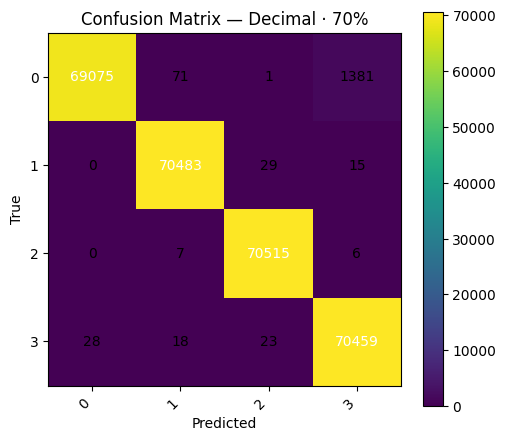

Classification Report:


precision,recall,f1-score,support
0.9996,0.9794,0.9894,70528.0000
0.9986,0.9994,0.9990,70527.0000
0.9992,0.9998,0.9995,70528.0000
0.9805,0.9990,0.9897,70528.0000
0.9944,0.9944,0.9944,0.9944
0.9945,0.9944,0.9944,282111.0000
0.9945,0.9944,0.9944,282111.0000


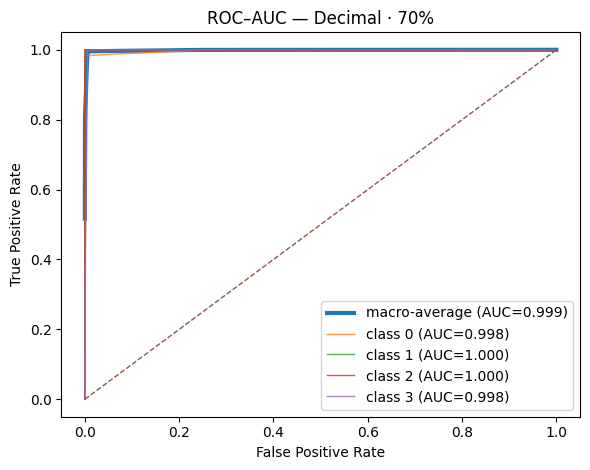

In [1]:
# ===============================================
# Single CSV → internal split 70/30
# BorderlineSMOTE on train-only · GNN (Single)
# Outputs: time, RAM, Confusion Matrix, Classification Report, ROC–AUC
# ===============================================

# In Colab, if needed:
# !pip -q install imbalanced-learn psutil

import os, time, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from imblearn.over_sampling import BorderlineSMOTE, RandomOverSampler

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from IPython.display import display

# ========= EDIT THIS =========
FILE_DATA = "train_70_BorderlineSMOTE.csv"   # <-- dataset for the 70% run
SCALER_NAME = "decimal"                      # "decimal" | "minmax" | "robust" | "standard"
# =============================

TARGET_COL, ID_COLS = "label", []
TRAIN_FRACTION = 0.70
SEED, EPOCHS, BATCH, VAL = 42, 30, 256, 0.15
VERBOSE = 1
np.random.seed(SEED); tf.keras.utils.set_random_seed(SEED)

def now_mem_gb():
    rss_gb = peak_gb = float("nan")
    try:
        import psutil
        p = psutil.Process(os.getpid()); rss_gb = p.memory_info().rss / (1024**3)
    except Exception: pass
    try:
        import resource
        r = resource.getrusage(resource.RUSAGE_SELF)
        peak_gb = r.ru_maxrss / (1024**2)  # KB -> GB on Linux
    except Exception: pass
    return rss_gb, peak_gb

class DecimalScaler:
    def fit(self, X):
        m = np.maximum(np.max(np.abs(X), axis=0), 1e-12)
        self.j_ = np.ceil(np.log10(m)).astype(np.float32); return self
    def transform(self, X): return X / (10.0 ** self.j_)
    def fit_transform(self, X): return self.fit(X).transform(X)

def get_scaler(name):
    nm = name.lower()
    if nm == "decimal":  return DecimalScaler()
    if nm == "minmax":   return MinMaxScaler()
    if nm == "robust":   return RobustScaler(quantile_range=(25.0, 75.0))
    if nm == "standard": return StandardScaler()
    raise ValueError(f"Unknown scaler: {name}")

def load_xy(path):
    df = pd.read_csv(path)
    auto_drop = [c for c in df.columns if c.lower().startswith("unnamed")]
    drops = [TARGET_COL] + [c for c in ID_COLS if c in df.columns] + auto_drop
    y = df[TARGET_COL].values
    X = df.drop(columns=[c for c in drops if c in df.columns], errors="ignore")
    X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median(numeric_only=True)).astype(np.float32).values
    return X, y

def build_gnn_proxy(d,k):
    i = layers.Input(shape=(d,))
    x = layers.Dense(256, activation="relu")(i); x = layers.BatchNormalization()(x); x = layers.Dropout(0.30)(x)
    x = layers.Dense(128, activation="relu")(x); x = layers.BatchNormalization()(x); x = layers.Dropout(0.20)(x)
    o = layers.Dense(k, activation="softmax")(x)
    m = models.Model(i,o)
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return m

def compute_metrics(y_true, probs, preds, classes):
    acc = accuracy_score(y_true, preds)
    try:
        auc_val = roc_auc_score(y_true, probs[:,1]) if len(classes)==2 else roc_auc_score(y_true, probs, multi_class="ovr")
    except Exception:
        auc_val = float("nan")
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, preds, average="weighted", zero_division=0)
    cm = confusion_matrix(y_true, preds)
    rep = classification_report(y_true, preds, target_names=[str(c) for c in classes],
                                zero_division=0, output_dict=True)
    return acc, auc_val, prec, rec, f1, cm, pd.DataFrame(rep).T

def plot_confusion_matrix(cm, classes, title):
    fig = plt.figure(figsize=(5.2, 4.6))
    plt.imshow(cm, interpolation="nearest"); plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha="right"); plt.yticks(ticks, classes)
    thr = cm.max()/2. if cm.size else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i,j], 'd'), ha="center", va="center",
                     color="white" if cm[i,j] > thr else "black")
    plt.tight_layout(); plt.show()

def plot_roc(y_true, probs, classes, title):
    k = len(classes); fig = plt.figure(figsize=(6.0, 4.8))
    if k == 2:
        fpr, tpr, _ = roc_curve(y_true, probs[:,1]); rauc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={rauc:.3f})")
    else:
        fpr_d, tpr_d, auc_d = {}, {}, {}
        for i in range(k):
            fpr_d[i], tpr_d[i], _ = roc_curve((y_true==i).astype(int), probs[:, i])
            auc_d[i] = auc(fpr_d[i], tpr_d[i])
        all_fpr = np.unique(np.concatenate([fpr_d[i] for i in range(k)]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(k): mean_tpr += np.interp(all_fpr, fpr_d[i], tpr_d[i])
        mean_tpr /= k; macro_auc = auc(all_fpr, mean_tpr)
        plt.plot(all_fpr, mean_tpr, lw=3, label=f"macro-average (AUC={macro_auc:.3f})")
        if k <= 6:
            for i in range(k): plt.plot(fpr_d[i], tpr_d[i], lw=1, alpha=0.8, label=f"class {classes[i]} (AUC={auc_d[i]:.3f})")
    plt.plot([0,1],[0,1],'--', lw=1); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

# ---- Load & map labels
assert os.path.exists(FILE_DATA), f"Data file not found: {FILE_DATA}"
X_all, y_all = load_xy(FILE_DATA)
classes, y_ids = np.unique(y_all, return_inverse=True)

# ---- 70% internal split
print("\n=== INTERNAL 70/30 | BorderlineSMOTE train-only ===")
t0 = time.perf_counter(); rss0, peak0 = now_mem_gb()

sss = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_FRACTION, random_state=42)
tr_idx, te_idx = next(sss.split(X_all, y_ids))
X_tr_raw, y_tr = X_all[tr_idx], y_ids[tr_idx]
X_te_raw, y_te = X_all[te_idx], y_ids[te_idx]

# Scale on TRAIN only
scaler = get_scaler(SCALER_NAME)
Xtr_s = scaler.fit_transform(X_tr_raw); Xte_s = scaler.transform(X_te_raw)

# BorderlineSMOTE on TRAIN ONLY
_, counts = np.unique(y_tr, return_counts=True)
min_count = counts.min()
if min_count < 2:
    X_bal, y_bal = RandomOverSampler(random_state=42).fit_resample(Xtr_s, y_tr)
    note = "ROS (too few minority samples for BSMOTE)"
else:
    k = max(1, min(5, min_count - 1))
    m = max(k + 1, min(10, Xtr_s.shape[0] - 1))
    try:
        bsmote = BorderlineSMOTE(kind="borderline-1", random_state=42, k_neighbors=k, m_neighbors=m)
        X_bal, y_bal = bsmote.fit_resample(Xtr_s, y_tr)
        note = f"BorderlineSMOTE(k={k}, m={m})"
    except Exception:
        X_bal, y_bal = RandomOverSampler(random_state=42).fit_resample(Xtr_s, y_tr)
        note = "ROS (BSMOTE fallback)"

# Model
model = build_gnn_proxy(X_bal.shape[1], len(classes))
cbs = [callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
       callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)]
model.fit(X_bal, y_bal, validation_split=0.15, epochs=EPOCHS, batch_size=BATCH,
          callbacks=cbs, verbose=VERBOSE)

# Evaluate
probs = model.predict(Xte_s, batch_size=BATCH, verbose=0)
preds = probs.argmax(axis=1)
acc, auc_val, prec, rec, f1, cm, rep_df = compute_metrics(y_te, probs, preds, list(range(len(classes))))

# timing + RAM
elapsed = time.perf_counter() - t0; rss1, peak1 = now_mem_gb()
print(note)
print(f"Time elapsed: {elapsed:.2f} sec")
if not math.isnan(rss1):  print(f"RAM RSS now: {rss1:.2f} GB  (Δ {rss1 - (rss0 if not math.isnan(rss0) else rss1):+.2f} GB)")
if not math.isnan(peak1): print(f"Peak RAM (process): {peak1:.2f} GB")
print(f"Acc={acc:.4f}  AUC={auc_val:.4f}  Prec_w={prec:.4f}  Recall_w={rec:.4f}  F1_w={f1:.4f}")

# Confusion Matrix
plot_confusion_matrix(cm, [str(c) for c in np.unique(y_ids)],
                      title=f"Confusion Matrix — {SCALER_NAME.title()} · 70%")

# Classification Report (styled)
print("Classification Report:")
styler = rep_df.style
if hasattr(styler, "hide_index"): display(styler.hide_index().format(precision=4))
elif hasattr(styler, "hide"):     display(styler.hide(axis="index").format(precision=4))
else:                              display(rep_df)

# ROC–AUC
plot_roc(y_te, probs, list(range(len(classes))), title=f"ROC–AUC — {SCALER_NAME.title()} · 70%")


In [2]:
# --- quick count checker: split + scale + BorderlineSMOTE, no training ---
import os, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import BorderlineSMOTE, RandomOverSampler
from IPython.display import display

FILE_DATA = "train_70_BorderlineSMOTE.csv"  # your 70 file
TARGET_COL, ID_COLS = "label", []
SCALER_NAME = "decimal"                     # "decimal" | "minmax" | "robust" | "standard"
TRAIN_FRACTION = 0.70
SEED = 42

class DecimalScaler:
    def fit(self, X):
        import numpy as np
        m = np.maximum(np.max(np.abs(X), axis=0), 1e-12)
        self.j_ = np.ceil(np.log10(m)).astype(np.float32); return self
    def transform(self, X): return X / (10.0 ** self.j_)
    def fit_transform(self, X): return self.fit(X).transform(X)

def get_scaler(name):
    nm = name.lower()
    if nm == "decimal":  return DecimalScaler()
    if nm == "minmax":   return MinMaxScaler()
    if nm == "robust":   return RobustScaler(quantile_range=(25.0, 75.0))
    if nm == "standard": return StandardScaler()
    raise ValueError(f"Unknown scaler: {name}")

def load_xy(path):
    df = pd.read_csv(path)
    auto_drop = [c for c in df.columns if c.lower().startswith("unnamed")]
    y = df[TARGET_COL].values
    X = df.drop(columns=[TARGET_COL] + [c for c in ID_COLS if c in df.columns] + auto_drop, errors="ignore")
    X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median(numeric_only=True)).astype(np.float32).values
    return X, y

def label_summary(y, name):
    import numpy as np
    labels, counts = np.unique(y, return_counts=True)
    pct = counts / counts.sum() * 100.0
    return pd.DataFrame({"Label": labels, f"Count ({name})": counts, f"% ({name})": np.round(pct, 2)})

def imbalance_ratio(y):
    import numpy as np
    _, counts = np.unique(y, return_counts=True)
    return counts.max() / max(1, counts.min())

assert os.path.exists(FILE_DATA), f"Data not found: {FILE_DATA}"
X_all, y_all = load_xy(FILE_DATA)
classes, y_ids = np.unique(y_all, return_inverse=True)

sss = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_FRACTION, random_state=SEED)
tr_idx, te_idx = next(sss.split(X_all, y_ids))
X_tr_raw, y_tr = X_all[tr_idx], y_ids[tr_idx]
X_te_raw, y_te = X_all[te_idx], y_ids[te_idx]

scaler = get_scaler(SCALER_NAME)
X_tr = scaler.fit_transform(X_tr_raw)
X_te = scaler.transform(X_te_raw)

# BorderlineSMOTE on train only
_, counts = np.unique(y_tr, return_counts=True)
min_count = counts.min()
if min_count < 2:
    X_bal, y_bal = RandomOverSampler(random_state=SEED).fit_resample(X_tr, y_tr)
else:
    k = max(1, min(5, min_count - 1))
    m = max(k + 1, min(10, X_tr.shape[0] - 1))
    try:
        bsmote = BorderlineSMOTE(kind="borderline-1", random_state=SEED, k_neighbors=k, m_neighbors=m)
        X_bal, y_bal = bsmote.fit_resample(X_tr, y_tr)
    except Exception:
        X_bal, y_bal = RandomOverSampler(random_state=SEED).fit_resample(X_tr, y_tr)

# show table
before_df = label_summary(y_tr,  "Train BEFORE")
after_df  = label_summary(y_bal, "Train AFTER")
test_df   = label_summary(y_te,  "Test")

dist_tbl = (before_df.merge(after_df, on="Label", how="outer")
                      .merge(test_df,  on="Label", how="outer")
                      .fillna(0).sort_values("Label"))
dist_tbl["Δ Count (After-Before)"] = dist_tbl["Count (Train AFTER)"] - dist_tbl["Count (Train BEFORE)"]
dist_tbl["× Multiplier"] = np.where(dist_tbl["Count (Train BEFORE)"]>0,
                                    np.round(dist_tbl["Count (Train AFTER)"] / dist_tbl["Count (Train BEFORE)"], 2),
                                    np.nan)

print("\n==== CLASS DISTRIBUTIONS (70/30) ====")
styler = dist_tbl.style
if hasattr(styler, "hide_index"):
    display(styler.hide_index().format(precision=2))
elif hasattr(styler, "hide"):
    display(styler.hide(axis="index").format(precision=2))
else:
    display(dist_tbl)

print(f"Imbalance ratio — Train BEFORE: {imbalance_ratio(y_tr):.3f}")
print(f"Imbalance ratio — Train AFTER : {imbalance_ratio(y_bal):.3f}")
print(f"Imbalance ratio — Test        : {imbalance_ratio(y_te):.3f}")



==== CLASS DISTRIBUTIONS (70/30) ====


Label,Count (Train BEFORE),% (Train BEFORE),Count (Train AFTER),% (Train AFTER),Count (Test),% (Test),Δ Count (After-Before),× Multiplier
0,164564,25.00,164565,25.00,70528,25.00,1,1.00
1,164565,25.00,164565,25.00,70527,25.00,0,1.00
2,164564,25.00,164565,25.00,70528,25.00,1,1.00
3,164564,25.00,164565,25.00,70528,25.00,1,1.00


Imbalance ratio — Train BEFORE: 1.000
Imbalance ratio — Train AFTER : 1.000
Imbalance ratio — Test        : 1.000
